In [71]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

In [72]:
#读取数据的函数
def get_data(file):
    data=load_svmlight_file(file)            #调用load_svmlight（）用于读取函数
    return data[0].todense(),data[1]            #返回值，第一个为训练特征数据，第二个为训练标签

In [73]:
#训练集读取数据
X_train,y_train=get_data('./a9a')                
#测试机读取数据
X_test,y_test=get_data('./a9a.t')

(n,m)=np.shape(X_train)                          #获取X_train的横纵维度
X_train=np.hstack((X_train,np.ones((n,1))))      #为训练数据的每一条数据增加一列，作为bias
(n,m)=np.shape(X_test)                          #获取X_test的横纵维度
X_test=np.hstack((X_test,np.zeros((n,1))))      #经发现，为第123列没有数据，故补充一列全零列
X_test=np.hstack((X_test,np.ones((n,1))))       #为测试数据的每一条数据增加一列，bias

In [74]:
#将y_train和y_test变为n*1的列向量
y_train=np.reshape(y_train,(len(y_train),1))
y_test=np.reshape(y_test,(len(y_test),1))

In [75]:
#将结果分类的函数
def sigmoid(X,w):
    h=1.0/(1+np.exp(-X*w))                             #用于预测结果分类的sigmod函数
    return h                                           

sigmoid函数公式为：
$$h_w(x)=\frac{1}{1+e^{-w^{T}x}}$$

In [76]:
#求梯度函数,其中正则系数lambda默认为0，还没有使用
def gradient(X,y,w,lamda=0):
    y_=X*w                                       #X与w相乘，得到预测结果
    y_y=np.multiply(y,y_)                        #y_y为y的i真实值和预测值的相应位置相乘值组成的向量，
    y_x=np.multiply(y,X)                          #y_x为矩阵X与y的相应位置相乘组成的结果
    grad=-np.mean(y_x/(1+np.exp(y_y)),0).T        #梯度计算公式，见以下公式
    
    return grad                  

梯度公式为:
$$\frac{\partial J}{\partial w}=-\frac{1}{m}\sum_{i=1}^{m}(1-g(y_i·W^Tx_i))（y_i·x_i)$$

In [77]:
#预测函数，预测y值大小
def predict(X,w):
    threshold=0.5                     #设置阈值
    y=np.ones((np.shape(X)[0],1))  
    h=sigmoid(X,w)                        #调用sigmod函数，计算h值的，用于预测y为1或者-1
    y[h>=threshold]=1                      #对于计算值h大于0.5的预测为1
    y[h<threshold]=-1                      #计算值值小于0.5的预测为-1
    return y

In [78]:
#准确率计算函数
def accuracy(X,w,y):
    y_predict=predict(X,w)                          #得到X，w的预测值{-1，1}
    N=np.zeros((len(y),1))                          #N用于接收结果
    N[y_predict==y]=1                               #如果预测值与真实值相同，则设置1，否则仍为0
                                
    return np.mean(N)                               #返回0，1矩阵的的均值，代表准确率                        

准确率计算公式为
$$accuracy=\frac{N_{true}}{N_{total}}$$

In [79]:
#交叉熵损失函数
def crossEntropyCost(X,y,w):
    y_=X*w                                         #X与w相乘，得到预测结果
    y_y=np.multiply(y_,y)                           #y_y为y的i真实值和预测值的相应位置相乘值组成的向量，
    loss=np.mean(np.log(1+np.exp(-y_y)))            #对y_y取对数求和并作均值计算，得到交叉熵损失
    return loss

交叉熵损失函数的公式为：
$$L_D(W)=-\frac{1}{m}\sum_{i=1}^mln(g(y_i·W^Tx_i)) $$

In [80]:
#未优化的sgd的实现函数
def SGD_gradient(X,y,w,eta):
    grad=gradient(X,y,w)           #计算梯度
    w=w-eta*grad                   #进行一步梯度下降
    return w

SGD实现原理：
$$g_t=\frac{\partial J(W_{t-1})}{\partial w}$$
$$W_t=W_{t-1}-\eta g_t$$

In [81]:
#NAG sgd的实现函数
def NAG_gradient(X,y,w,v,gamma,eta):
    grad=gradient(X,y,w-gamma*v)    #计算梯度
    v=gamma*v+eta*grad              #更新v值
    w=w-v                           #梯度下降
    return w,v

NAG实现原理：
$$g_t=\frac{\partial J}{\partial w}(W_{t-1}-\gamma v_{t-1})$$
$$v_t=\gamma v_{t-1}+\eta g_{t-1}$$
$$W_t=W_{t-1}-v_t$$

In [82]:
#RMS sgd的实现函数
def RMS_gradient(X,y,w,G,ganma,etha,epison):
    grad=gradient(X,y,w)                            #计算梯度
    dotMultiply=np.multiply(grad,grad)              #梯度进行点乘
    G=ganma*G+(1-ganma)*dotMultiply                 #G值由过去的G值和新的梯度点乘求得
    dot=np.multiply(etha/(np.sqrt(G+epison)),grad)    
    w=w-dot                                         #梯度下降
    return w,G

RMS实现原理：
$$g_t=\frac{\partial J(W_{t-1})}{\partial w}$$
$$G_t=\gamma G_t+(1-\gamma)g_t·g_t)$$

$$W_t=W_{t-1}-\frac{\eta}{\sqrt{G_t+\epsilon }}·g_t$$

In [83]:
#Adadelta sgd实现
def Adadelta_gradient(X,y,w,G,gamma,delta,epision):
    grad=gradient(X,y,w)                                         #计算梯度
    dotMultiply=np.multiply(grad,grad)                           #梯度进行点乘
    G=gamma*G+(1-gamma)*dotMultiply                              #G值由过去的G值和新的梯度点乘求得
    w_delta=-np.multiply(np.sqrt(delta+epision)/np.sqrt(G+epision),grad)  #w_delta计算
    w=w+w_delta                                                  #梯度下降
    delta=gamma*delta+(1-gamma)*(np.multiply(w_delta,w_delta))   #新delta由过去的delta值和新的w_delta的点乘求得
    return w,G,delta

#Adadelta实现原理
$$g_t=\Delta J(W_{t-1}$$
$$G_t=\gamma W_t+(1-\gamma)g_t·g_t$$
$$\Delta W_t=-\frac{\sqrt{\Delta _{t-1}+\epsilon}}{\sqrt{G_t+\epsilon }}·g_t$$
$$W_t=W_{t-1}+\Delta W_t$$
$$\Delta _t=\gamma \Delta _{t-1}+(1-\gamma)\Delta W_t·\Delta W_t$$

In [84]:
#Adam sgd实现
def Adam_gradient(X,y,w,G,m,ganma,t,etha,belta,epision):
    grad=gradient(X,y,w)                                           #计算梯度
    m=belta*m+(1-belta)*grad                                       #根据原有的m值和新求得grad计算m
    G=ganma*G+(1-ganma)*(np.multiply(grad,grad))                   #G值由过去的G值和新的梯度点乘求得
    alpha=etha*(np.sqrt(1-math.pow(ganma,t))/(1-math.pow(belta,t))) #计算alpha
    w=w-alpha*(m/(np.sqrt(G+epision)))                              #梯度下降
    return w,G,m

Adam的实现原理：
$$g_t=\frac{\partial J(W_{t-1})}{\partial} w$$
$$m_t=\beta _1m_{t-1}+(1-\beta)g_t$$
$$G_t=\gamma G_t+(1-\gamma)g_t·g_t$$
$$\alpha=\eta\frac{\sqrt{1-\gamma ^t}}{1-\beta ^t}$$
$$\Theta=\Theta_{t-1}-\alpha\frac{m_t}{\sqrt{G_t+\epsilon}}$$

In [85]:
#分别为NAG,RMSProb,Adadelta,Adam初始化权重向量等
(n,m)=np.shape(X_train)
#SGD初始化权重矩阵
w_sgd=np.zeros((m,1))


#NAG初始化权重矩阵
w_nag=np.zeros((m,1))
v_nag=np.zeros((m,1))
#RMS初始化权重矩阵
w_rms=np.zeros((m,1))
G_rms=np.zeros((m,1))
#Adadelta初始化权重矩阵
w_ada=np.zeros((m,1))
G_ada=np.zeros((m,1))
delta=np.zeros((m,1))
#Adam初始化权重矩阵
w_adam=np.zeros((m,1))
G_adam=np.zeros((m,1))
m_adam=np.zeros((m,1))

#迭代次数
epco=4000 
times=range(epco)

In [86]:
#定义未优化的SGD函数
def SGD(X,y,w_sgd,eta,train_size,epco,gradient=SGD_gradient,loss=crossEntropyCost,accuracy=accuracy):
    sgd_train=[]                       #训练误差列表
    sgd_test=[]                            #测试误差列表
    sgd_accuracy_train=[]                   #训练准确率列表
    sgd_accuracy_test=[]                    #测试准确率列表
    #开始进行梯度下降过程
    for i in range(epco):
        #得到用于梯度下降的小部分样本，即X_trainset,y_trainset
        X_trainset,X_other,y_trainset,y_other=train_test_split(X,y,test_size=1-train_size,random_state=random.randint(0,1000))
        #调用未优化的sgd的梯度下降函数，每一次迭代进行一步梯度下降
        w_sgd=gradient(X_trainset,y_trainset,w_sgd,eta)
        sgd_train.append(loss(X_trainset,y_trainset,w_sgd))            #得到训练和测试的loss
        sgd_test.append(loss(X_test,y_test,w_sgd))
        sgd_accuracy_train.append(accuracy(X_train,w_sgd,y_train))          #计算训练和测试的准确率
        sgd_accuracy_test.append(accuracy(X_test,w_sgd,y_test))
    return sgd_train,sgd_test,sgd_accuracy_train,sgd_accuracy_test
#参数初始化
eta=0.008                            #学习率设为0.01
train_size=0.0005               #指用于训练SGD的样本数占X_train的比例,约有15个样本用于训练
#开始训练，得到训练误差，测试误差，训练准确率和测试准确率
sgd_train,sgd_test,sgd_accuracy_train,sgd_accuracy_test=SGD(X=X_train,y=y_train,w_sgd=w_sgd,eta=eta,train_size=train_size,epco=epco)


In [87]:
#定义NAG sgd的训练函数
def NAG(X,y,w_nag,v_nag,gamma,eta,train_size,gradient=NAG_gradient,loss=crossEntropyCost,accuracy=accuracy):
    nag_train=[]                     #训练误差列表
    nag_test=[]                      #测试误差列表
    nag_accuracy_train=[]            #训练准确率列表
    nag_accuracy_test=[]             #测试准确率列表
    for i in range(epco):
        #得到用于随机梯度下降训练的小部分样本  {即X_trainset,y_trainset}
        X_trainset,X_other,y_trainset,y_other=train_test_split(X,y,test_size=1-train_size,random_state=random.randint(0,1000))
        #调用NG_gradient,每一次迭代进行一次梯度下降
        w_nag,v_nag=gradient(X_trainset,y_trainset,w_nag,v_nag,gamma,eta)
        nag_train.append(loss(X_trainset,y_trainset,w_nag))                #得到训练和测试的loss
        nag_test.append(loss(X_test,y_test,w_nag))
        nag_accuracy_train.append(accuracy(X_trainset,w_nag,y_trainset))  #计算训练和测试的准确率
        nag_accuracy_test.append(accuracy(X_test,w_nag,y_test))
    return nag_train,nag_test,nag_accuracy_train,nag_accuracy_test
#参数初始化
gamma=0.9
eta=0.001                       #学习率设为0.001
train_size=0.0005              #指用于训练SGD的样本数占X_train的比例，约有15个样本用于训练
#开始训练，得到训练误差，测试误差，训练准确率和测试准确率
nag_train,nag_test,nag_accuracy_train,nag_accuracy_test=NAG(X=X_train,y=y_train,w_nag=w_nag,v_nag=v_nag,gamma=gamma,eta=eta,train_size=train_size)

In [88]:
#定义RMS sgd的实现方法
def RMS(X,y,w_rms,G_rms,gamma,eta,epco,train_size,gradient=RMS_gradient,loss=crossEntropyCost,accuracy=accuracy):
    epision=0.0001                   #设置epision为0.0001，既避免Gt为零时的错误，也减小该参数对结果的影响   
    rms_train=[]                     #训练误差列表
    rms_test=[]                      #测试误差列表
    rms_accuracy_train=[]           #训练准确率列表
    rms_accuracy_test=[]            #测试准确率列表
    for i in range(epco):
        #得到用于随机梯度下降训练的小部分样本
        X_trainset,X_other,y_trainset,y_other=train_test_split(X,y,test_size=1-train_size,random_state=random.randint(0,1000))
        w_rms,G_rms=gradient(X_trainset,y_trainset,w_rms,G_rms,gamma,eta,epision)    #梯度下降更新
        rms_train.append(loss(X_trainset,y_trainset,w_rms))              #得到训练和测试的loss
        rms_test.append(loss(X_test,y_test,w_rms))
        rms_accuracy_train.append(accuracy(X_trainset,w_rms,y_trainset))  #计算准确率
        rms_accuracy_test.append(accuracy(X_test,w_rms,y_test))
    return rms_train,rms_test,rms_accuracy_train,rms_accuracy_test
#参数初始化
gamma=0.9
eta=0.001                                                        #学习率设为0.001
train_size=0.0005                                                #指用于训练SGD的样本数占X_train的比例
#开始训练，得到训练误差，测试误差，训练准确率和测试准确率
rms_train,rms_test,rms_accuracy_train,rms_accuracy_test=RMS(X=X_train,y=y_train,w_rms=w_rms,G_rms=G_rms,gamma=gamma,eta=eta,epco=epco,train_size=train_size)

In [89]:
#定义Adadelta sgd的实现方法
def Adadelta(X,y,w_ada,G_ada,delta,gamma,eta,epco,train_size,gradient=Adadelta_gradient,loss=crossEntropyCost,accuracy=accuracy):
    epision=0.000001                           #设置epision为0.0001，既避免Gt为零时的错误，也减小该参数对结果的影响               
    ada_train=[]                               #训练误差列表
    ada_test=[]                                   #测试误差列表
    ada_accuracy_train=[]                           #训练准确率列表
    ada_accuracy_test=[]                               #测试准确率列表
    for i in range(epco):
        #得到用于随机梯度下降训练的小部分样本
        X_trainset,X_other,y_trainset,y_other=train_test_split(X,y,test_size=1-train_size,random_state=random.randint(0,1000))        
        #调用Adadelta_gradient,每一次迭代进行一次梯度下降
        w_ada,G_ada,delta=gradient(X_trainset,y_trainset,w_ada,G_ada,gamma,delta,epision)
        ada_train.append(loss(X_trainset,y_trainset,w_ada))           #得到训练和测试的loss
        ada_test.append(loss(X_test,y_test,w_ada))
        ada_accuracy_train.append(accuracy(X_trainset,w_ada,y_trainset)) #计算训练和测试准确率
        ada_accuracy_test.append(accuracy(X_test,w_ada,y_test))
    
    return ada_train,ada_test,ada_accuracy_train,ada_accuracy_test
#参数初始化
gamma=0.9
eta=0.00001                                               #学习率设为0.001
train_size=0.0005                                        #指用于训练SGD的样本数占X_train的比例
#开始训练，得到训练误差，测试误差，训练准确率和测试准确率
ada_train,ada_test,ada_accuracy_train,ada_accuracy_test=Adadelta(X=X_train,y=y_train,w_ada=w_ada,G_ada=G_ada,delta=delta,gamma=gamma,eta=eta,epco=epco,train_size=train_size)

In [90]:
#定义Adam sgd的实现方法
def Adam(X,y,w_adam,G_adam,m_adam,gamma,eta,epco,train_size,gradient=Adam_gradient,loss=crossEntropyCost,accuracy=accuracy):
    epision=0.0001                          #设置epision为0.0001，既避免Gt为零时的错误，也减小该参数对结果的影响
    adam_train=[]                       #训练误差列表
    adam_test=[]                         #测试误差列表
    adam_accuracy_train=[]                #训练准确率列表
    adam_accuracy_test=[]                 #测试准确率列表
    for i in range(epco):
        #得到用于随机梯度下降训练的小部分样本
        X_trainset,X_other,y_trainset,y_other=train_test_split(X,y,test_size=1-train_size,random_state=random.randint(0,1000))        
        # 调用Adam_gradient,每一次迭代进行一次梯度下降
        w_adam,G_adam,m_adam=gradient(X_trainset,y_trainset,w_adam,G_adam,m_adam,gamma,i+1,etha,belta,epision)
        adam_train.append(loss(X_trainset,y_trainset,w_adam))              #得到训练和测试的loss
        adam_test.append(loss(X_test,y_test,w_adam))
        adam_accuracy_train.append(accuracy(X_trainset,w_adam,y_trainset))  #计算训练和测试准确率
        adam_accuracy_test.append(accuracy(X_test,w_adam,y_test))
    return adam_train,adam_test,adam_accuracy_train,adam_accuracy_test
#参数初始化
gamma=0.9
etha=0.0008                                       #学习率设为0.01
belta=0.9                                      
train_size=0.0005                                 #指用于训练SGD的样本数占X_train的比例
#开始训练，得到训练误差，测试误差，训练准确率和测试准确率
adam_train,adam_test,adam_accuracy_train,adam_accuracy_test=Adam(X=X_train,y=y_train,w_adam=w_adam,G_adam=G_adam,m_adam=m_adam,gamma=gamma,eta=eta,epco=epco,train_size=train_size)


In [91]:
#打印出每种方法最后的准确率
print('sgd accuracy:',sgd_accuracy_test[-1])
print('nag accuracy:',nag_accuracy_test[-1])
print("rmsprob accuracy:",rms_accuracy_test[-1])
print("adadelta accuracy:",ada_accuracy_test[-1])
print("adam accuracy:",adam_accuracy_test[-1])

sgd accuracy: 0.837417849026
nag accuracy: 0.839690436705
rmsprob accuracy: 0.849026472575
adadelta accuracy: 0.849149315153
adam accuracy: 0.846692463608


(4000,)


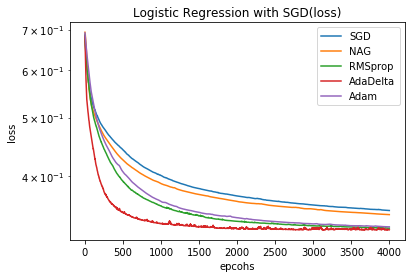

In [92]:
#打印出各种实现方法的loss曲线
plt.yscale('log')
plt.title('Logistic Regression with SGD(loss)') 
plt.xlabel('epcohs')
plt.ylabel('loss')
print(np.shape(sgd_test))
plt.plot(times,sgd_test,label="SGD")
plt.plot(times,nag_test,label="NAG")
plt.plot(times,rms_test,label="RMSprop")
plt.plot(times,ada_test,label="AdaDelta")
plt.plot(times,adam_test,label="Adam")
plt.legend()
plt.show()

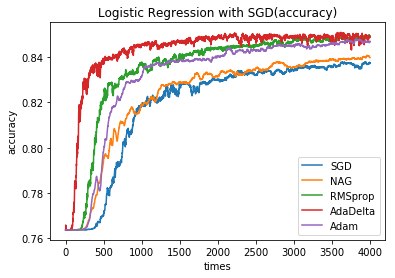

In [93]:
#打印出各种是先放的准确率曲线
plt.title('Logistic Regression with SGD(accuracy)')
plt.xlabel('times')
plt.ylabel('accuracy')
plt.plot(times,sgd_accuracy_test,label="SGD")
plt.plot(times,nag_accuracy_test,label="NAG")
plt.plot(times,rms_accuracy_test,label="RMSprop")
plt.plot(times,ada_accuracy_test,label="AdaDelta")
plt.plot(times,adam_accuracy_test,label="Adam")
plt.legend()
plt.show()